In [30]:
from su2_element import SU2_element
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid']) #dependency: SciencePlots
from fibonacci import generate_vertices
from linear_discetisation import Linear_disc_points
from genz_recreate import gen_all_points
from commutators import test_angular_momentum_comutator, fourier_vector, calc_r, La_Lb_commutator
from lattice_actions import calc_mean_distance
from derivative import angular_momentum, new_angular_momentum, mp_new_angular_momentum, angular_momentum_two_neighbors_new
import pathlib
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool



Lattice_Path = pathlib.Path("lattices")

In [31]:
# create Lattices

N = np.array([i for i in range(5,11)])
lin_Lattices = [gen_all_points(i) for i in N]
fib_Lattices = []
optim_Lattices = []
for i in N:
    fib_path = list(Lattice_Path.absolute().glob(f"**/fib_{int(2**i)}.csv"))[0]
    optim_path = list(Lattice_Path.absolute().glob(f"**/optim_{int(2**i)}.csv"))[0]
    fib_Lattices.append(np.loadtxt(fib_path))
    optim_Lattices.append(np.loadtxt(optim_path))

#define initial params
ks = np.array([[0,0,0],[0.1,0,0],[0.5,0,0],[1,0,0]])
neighbors = [1,2,3,4]
Is = [0,1]
Js = [0,1]
As = [1,2,3]
angs = [angular_momentum, new_angular_momentum]

In [32]:
lin_res = np.zeros((ks.shape[0], len(lin_Lattices)))
fib_res = np.zeros((ks.shape[0], len(fib_Lattices)))
opt_res = np.zeros((ks.shape[0], len(optim_Lattices)))

for index, (lin, fib, opt) in enumerate(zip(lin_Lattices,fib_Lattices,optim_Lattices)):
    lin_comm = test_angular_momentum_comutator(lin, 1, i=1, j=1, ang=angular_momentum_two_neighbors_new)
    fib_comm = test_angular_momentum_comutator(fib, 1, i=1, j=1, ang=angular_momentum_two_neighbors_new)
    opt_comm = test_angular_momentum_comutator(opt, 1, i=1, j=1, ang=angular_momentum_two_neighbors_new)
    for i_k, k in enumerate(ks):
        lin_vec = fourier_vector(lin, 1, k)
        fib_vec = fourier_vector(fib, 1, k)
        opt_vec = fourier_vector(opt, 1, k)
        lin_res[i_k, index] = calc_r(lin_comm, vec=lin_vec)
        fib_res[i_k, index] = calc_r(fib_comm, vec=fib_vec)
        opt_res[i_k, index] = calc_r(opt_comm, vec=opt_vec)

In [27]:
opt_res

array([[1.32086392, 1.36003217, 2.27578051, 3.45173896, 2.84742173,
        5.40405915],
       [1.26342148, 1.41040857, 2.39978082, 3.42533088, 2.88480525,
        5.44062723],
       [1.286713  , 1.64246865, 3.02345278, 3.64688843, 3.33033872,
        5.74824265],
       [1.58667537, 1.9586362 , 3.94713245, 4.59317873, 4.20012637,
        6.30169257]])

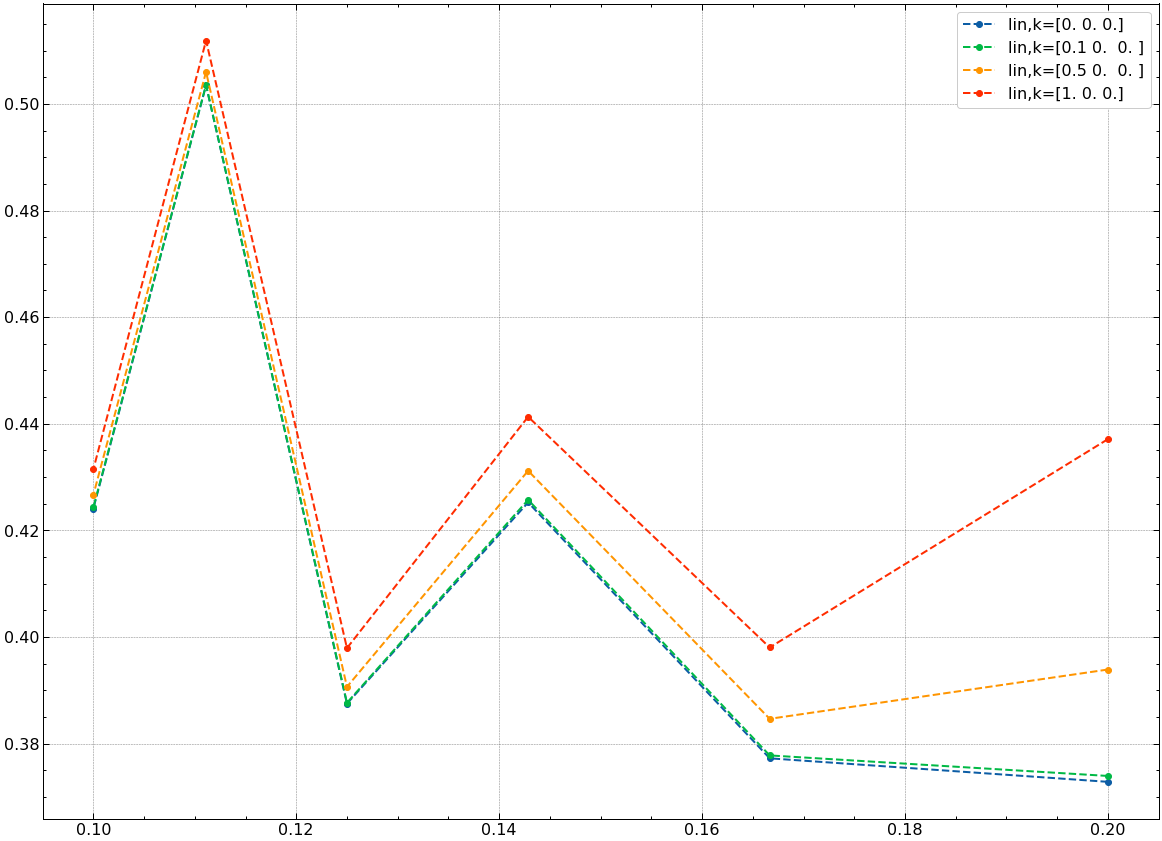

In [44]:
fig, axes = plt.subplots(1,1,figsize=(20,15))

for i_k, _ in enumerate(ks):
    
    axes.plot(1/N, lin_res[i_k,:],"o--",label=f"lin,k={ks[i_k]}") 
    #axes.plot(1/N, fib_res[i_k,:],"o--",label=f"fib,k={ks[i_k]}")
    #axes.plot(1/N, opt_res[i_k,:],label=f"opt,k={ks[i_k]}")
axes.legend(loc="best")

In [4]:

lin_res = np.zeros((len(neighbors), len(As), len(As), ks.shape[0], len(angs), len(lin_Lattices)))
fib_res = np.zeros((len(neighbors), len(As), len(As), ks.shape[0], len(angs), len(fib_Lattices)))
opt_res = np.zeros((len(neighbors), len(As), len(As), ks.shape[0], len(angs), len(optim_Lattices)))

mean_distances= []

for i_n, n in enumerate(neighbors):
    for i_a, a in enumerate(As):
        for i_b, b in enumerate(As):
            if a==b:
                continue
            for i_ang, ang in enumerate(angs):
                for index, (lin, fib, opt) in enumerate(zip(lin_Lattices,fib_Lattices,optim_Lattices)):
                    lin_comm = La_Lb_commutator(lin, a, b, n=n, ang=ang)
                    fib_comm = La_Lb_commutator(fib, a, b, n=n, ang=ang)
                    opt_comm = La_Lb_commutator(opt, a, b, n=n, ang=ang)
                    for i_k, k in enumerate(ks):
                        lin_vec = fourier_vector(lin, 1, k)
                        fib_vec = fourier_vector(fib, 1, k)
                        opt_vec = fourier_vector(opt, 1, k)
                        lin_res[i_n, i_a, i_b, i_k, i_ang] = calc_r(lin_comm, vec=lin_vec)
                        fib_res[i_n, i_a, i_b, i_k, i_ang] = calc_r(fib_comm, vec=fib_vec)
                        opt_res[i_n, i_a, i_b, i_k, i_ang] = calc_r(opt_comm, vec=opt_vec)
                    
lin_LaLb = lin_res.copy()
fib_LaLb = fib_res.copy()
opt_LaLb = opt_res.copy()

In [3]:

lin_res = np.zeros((len(neighbors), len(As), len(As), ks.shape[0], len(angs), len(lin_Lattices)))
fib_res = np.zeros((len(neighbors), len(As), len(As), ks.shape[0], len(angs), len(fib_Lattices)))
opt_res = np.zeros((len(neighbors), len(As), len(As), ks.shape[0], len(angs), len(optim_Lattices)))

mean_distances= []

for i_n, n in enumerate(neighbors):
    for i_a, a in enumerate(As):
        for i_b, b in enumerate(As):
            if a==b:
                continue
            for i_ang, ang in enumerate(angs):
                for index, (lin, fib, opt) in enumerate(zip(lin_Lattices,fib_Lattices,optim_Lattices)):
                    lin_comm = La_Lb_commutator(lin, a, b, n=n, ang=ang)
                    fib_comm = La_Lb_commutator(fib, a, b, n=n, ang=ang)
                    opt_comm = La_Lb_commutator(opt, a, b, n=n, ang=ang)
                    for i_k, k in enumerate(ks):
                        lin_vec = fourier_vector(lin, 1, k)
                        fib_vec = fourier_vector(fib, 1, k)
                        opt_vec = fourier_vector(opt, 1, k)
                        lin_res[i_n, i_a, i_b, i_k, i_ang] = calc_r(lin_comm, vec=lin_vec)
                        fib_res[i_n, i_a, i_b, i_k, i_ang] = calc_r(fib_comm, vec=fib_vec)
                        opt_res[i_n, i_a, i_b, i_k, i_ang] = calc_r(opt_comm, vec=opt_vec)
                    
lin_LaLb = lin_res.copy()
fib_LaLb = fib_res.copy()
opt_LaLb = opt_res.copy()

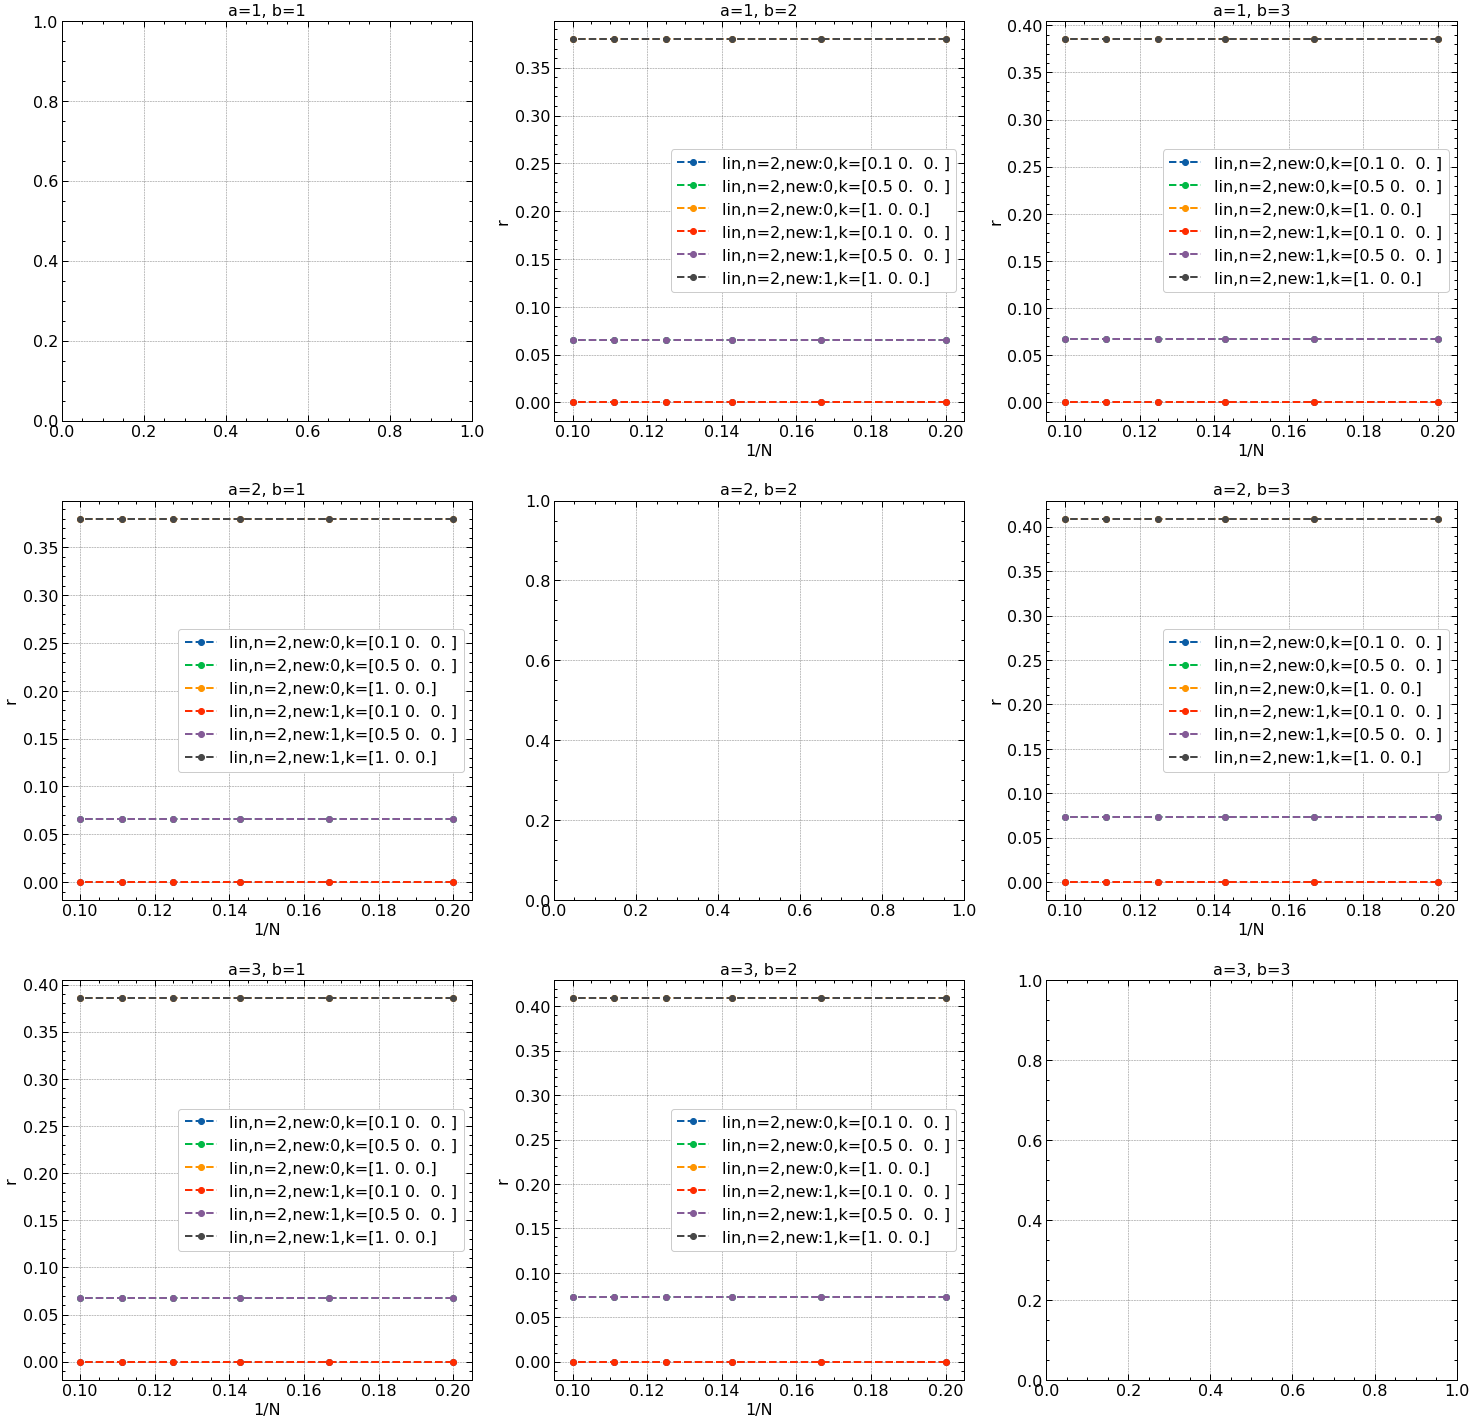

In [4]:
fig, axes = plt.subplots(3,3,figsize=(25,25))

for i_n, n in enumerate(neighbors[1:2]):
    for i_a, a in enumerate(As):
        for i_b, b in enumerate(As):
            ax = axes[i_a][i_b]
            ax.set_title(f"a={a}, b={b}")
            if a==b:
                continue
            for i_ang, ang in enumerate(angs[:2]):
                for i_k, k in enumerate(ks[1:4]):
                    y = lin_LaLb[i_n, i_a, i_b, i_k, i_ang]
                    ax.plot(1/N, y, "o--", label=f"lin,n={n},new:{i_ang},k={k}")
                    #y = fib_LaLb[i_n, i_a, i_b, i_k, i_ang]
                    #ax.plot(1/N, y, "o--", label=f"fib,n={n},new:{i_ang},k={k}")
                    #y = opt_LaLb[i_n, i_a, i_b, i_k, i_ang]
                    #ax.plot(1/N, y, "o--", label=f"opt,n={n},new:{i_ang},k={k}")

            ax.set_ylabel("r")
            ax.set_xlabel("1/N")
            ax.legend(loc="best")
            #ax.set_yscale("log")

In [7]:

mean_distances= []
lin_res = np.zeros((len(neighbors),len(Is), len(Js), len(As), ks.shape[0], len(angs), len(lin_Lattices)))
fib_res = np.zeros((len(neighbors),len(Is), len(Js), len(As), ks.shape[0], len(angs), len(fib_Lattices)))
opt_res = np.zeros((len(neighbors),len(Is), len(Js), len(As), ks.shape[0], len(angs), len(optim_Lattices)))


for i_n, n in enumerate(neighbors):
    for i in [0,1]:
        for j in [0,1]:
            for a in [1,2,3]:
                for i_ang, ang in enumerate(angs):
                    for index, (lin, fib, opt) in enumerate(zip(lin_Lattices,fib_Lattices,optim_Lattices)):
                        lin_comm = test_angular_momentum_comutator(lin, a, n=n, i=i,j=j, ang=ang)
                        fib_comm = test_angular_momentum_comutator(fib, a, n=n, i=i,j=j, ang=ang)
                        opt_comm = test_angular_momentum_comutator(opt, a, n=n, i=i,j=j, ang=ang)
                        for i_k, k in enumerate(ks):
                            vec = fourier_vector(lin, a, k)
                            lin_res[i_n, i, j, a-1, i_k, i_ang, index] = calc_r(lin_comm, vec=vec).real
                            vec = fourier_vector(fib, a, k)
                            fib_res[i_n, i, j, a-1, i_k, i_ang, index] = calc_r(fib_comm, vec=vec).real
                            vec = fourier_vector(opt, a, k)
                            opt_res[i_n, i, j, a-1, i_k, i_ang, index] = calc_r(opt_comm, vec=vec).real
                    
lin_res = np.mean(lin_res, axis=3)
fib_res = np.mean(fib_res, axis=3)
opt_res = np.mean(opt_res, axis=3)

lin_LaU = lin_res.copy()
fib_LaU = fib_res.copy()
opt_LaU = opt_res.copy()

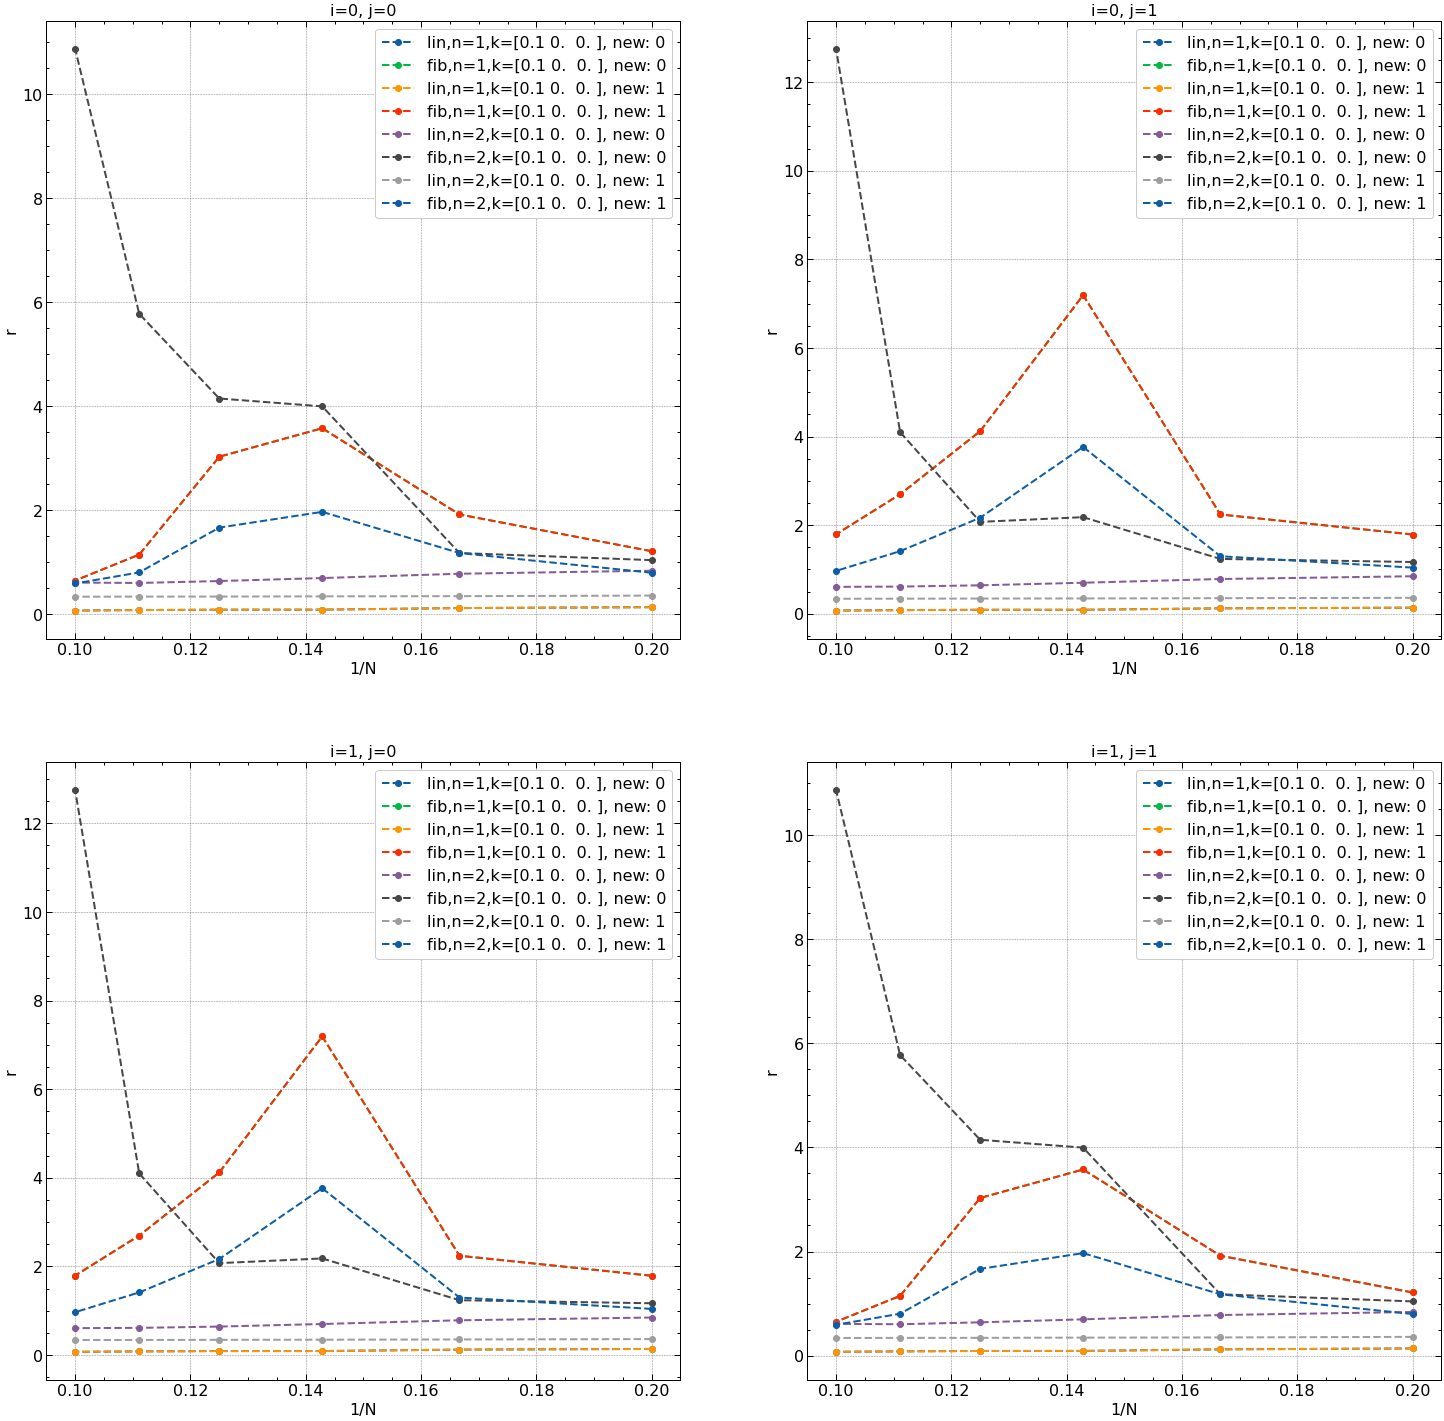

In [41]:
fig, axes = plt.subplots(2,2,figsize=(25,25))

#plotting
for i0, n in enumerate(neighbors[:2]):
    for i1, i in enumerate(Is):
        for i2, j in enumerate(Js):
            ax = axes[i1][i2]
            for i3, k in enumerate(ks[1:2]):
                for i4, _ in enumerate(angs[:2]):                
                    y = lin_LaU[i0,i1,i2,i3,i4]
                    ax.plot(1/N, y, 'o--', label=f"lin,n={n},k={k}, new: {i4}")
                    y = fib_LaU[i0,i1,i2,i3,i4]
                    ax.plot(1/N, y, 'o--', label=f"fib,n={n},k={k}, new: {i4}")
                    #y = opt_LaU[i0,i1,i2,i3,i4]
                    #ax.plot(1/N, y, 'o--', label=f"opt,n={n},k={k}, new: {i4}")
            ax.set_title(f"i={i}, j={j}")
            ax.legend(loc="best")
            ax.set_ylabel("r")
            ax.set_xlabel("1/N")

\begin{equation*}
    z = \big([L_a,U_{il}] - (t_a)_{ji} U_{il})\cdot v(k)
\end{equation*}

\begin{equation*}
    r = \frac{1}{N}\sum_i |z_i|
\end{equation*}

### Eigenvalues

In [22]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid']) #dependency: SciencePlots
from fibonacci import generate_vertices, generate_vertices_angles
from lattice_optimisation import lattice_optimizer, angles_to_cartesian
from hamiltonian import calc_eigenvals, continuum_spectrum, generate_Ldagger_L
from derivative import new_angular_momentum

num_eigenvals = 75
id_s = list(range(num_eigenvals))
eigenvals = continuum_spectrum(num_eigenvals)


neighbors = [1,2,4]
exponents = [8,10, 11,12]
fib_Lattices = [generate_vertices(2**i) for i in exponents]
optim_Lattices = [angles_to_cartesian(lattice_optimizer(generate_vertices_angles(2**i))[0]) for i in exponents]

fib_eigenvals = np.zeros((len(neighbors),len(exponents), num_eigenvals))
optim_eigenvals = np.zeros((len(neighbors),len(exponents), num_eigenvals))
print(fib_eigenvals.shape)

for index, (exponent, fib, optim) in enumerate(zip(exponents,fib_Lattices, optim_Lattices)):
    for i,n in enumerate(neighbors):
        fib_L = generate_Ldagger_L(fib,n=n)#,ang=new_angular_momentum)
        fib_eigenvals[i,index,:] = calc_eigenvals(fib_L, k=num_eigenvals)
        optim_L = generate_Ldagger_L(optim,n=n)#, ang=new_angular_momentum)
        optim_eigenvals[i,index,:] = calc_eigenvals(optim_L, k=num_eigenvals)

(3, 4, 75)


<ipython-input-22-062293e061a8>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  fib_eigenvals[i,index,:] = calc_eigenvals(fib_L, k=num_eigenvals)
<ipython-input-22-062293e061a8>:28: ComplexWarning: Casting complex values to real discards the imaginary part
  optim_eigenvals[i,index,:] = calc_eigenvals(optim_L, k=num_eigenvals)


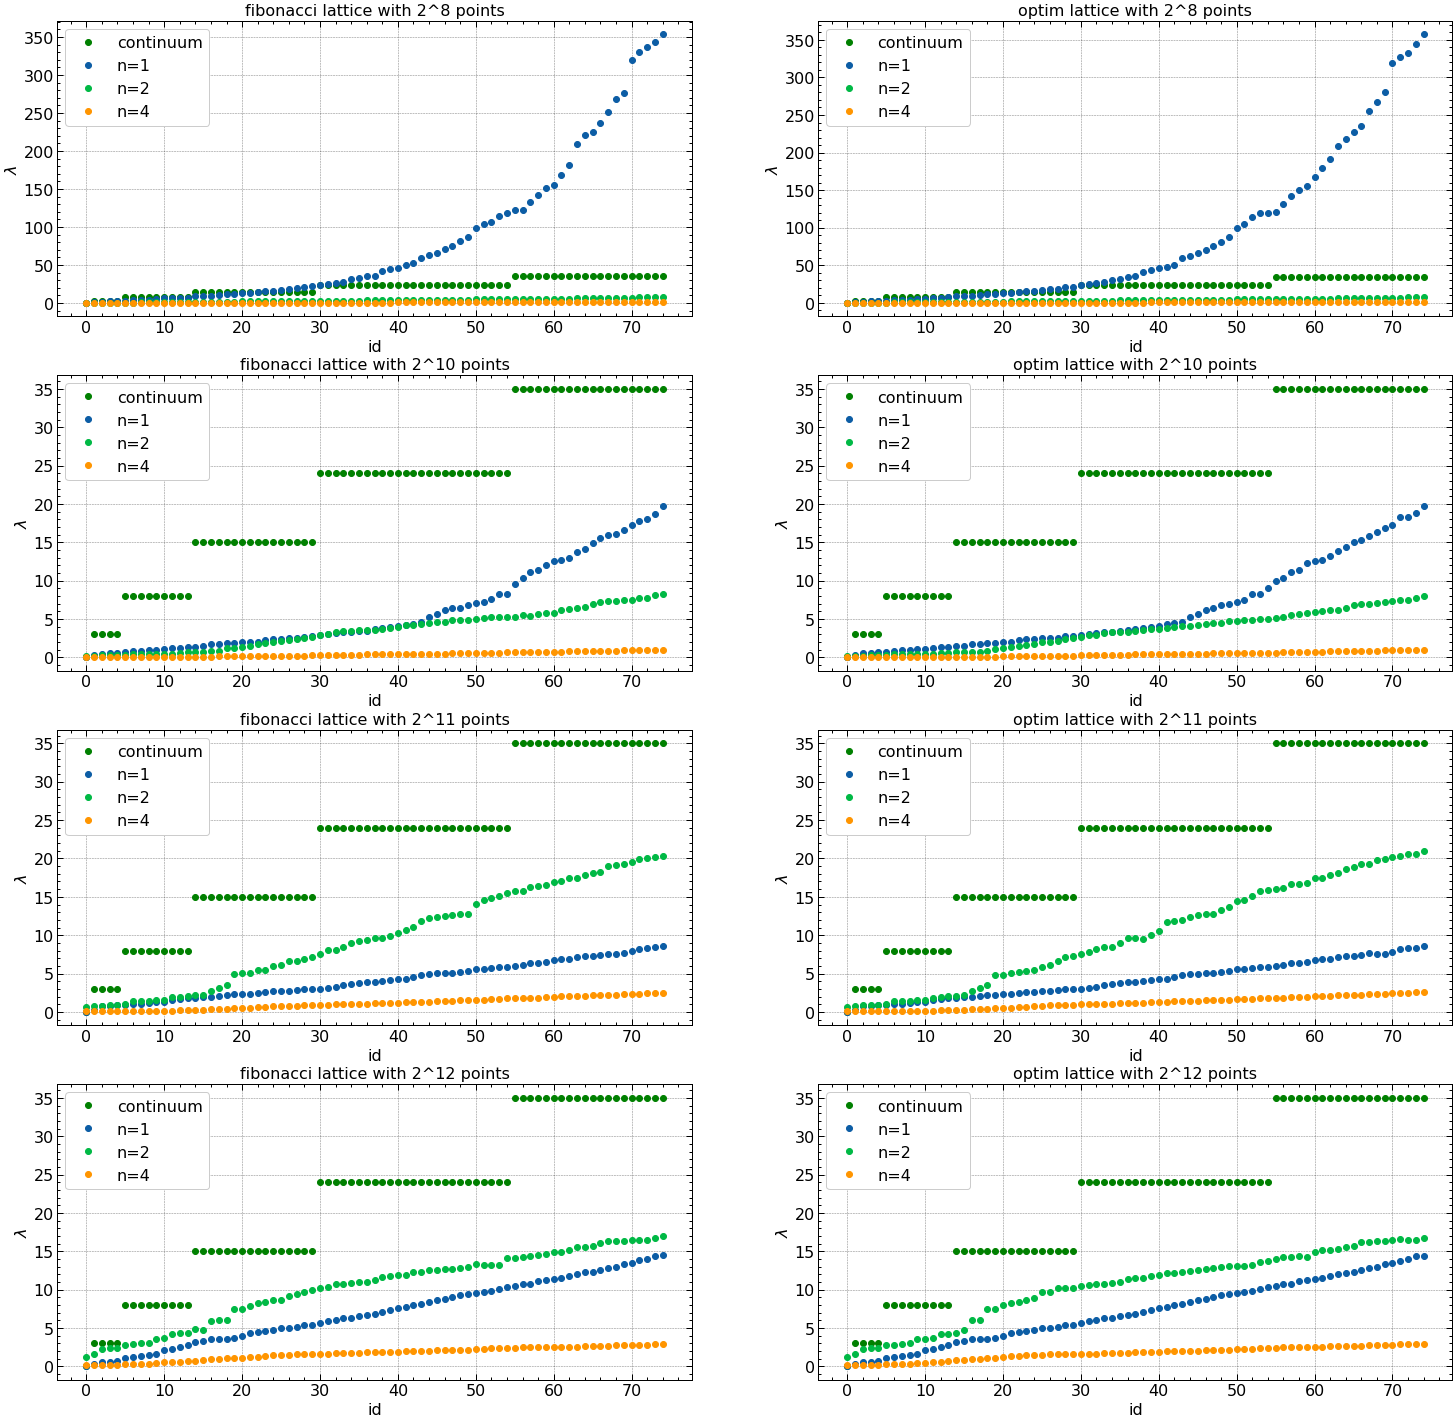

In [23]:
fig, axes = plt.subplots(len(exponents),2,figsize=(25,25))

for index, exponent in enumerate(exponents):
    ax = axes[index,:]
    ax[0].plot(id_s, eigenvals, "o", label = "continuum", color="green")
    ax[1].plot(id_s, eigenvals, "o", label = "continuum", color="green")
    for i,n in enumerate(neighbors):
        ax[0].plot(id_s, fib_eigenvals[i,index,:], "o", label=rf"n={n}")
        ax[1].plot(id_s, optim_eigenvals[i,index,:], "o", label=rf"n={n}")
    ax[0].set_title(rf"fibonacci lattice with 2^{exponent} points")
    ax[1].set_title(rf"optim lattice with 2^{exponent} points")
    ax[0].legend(loc="best")
    ax[1].legend(loc="best")
    ax[0].set_xlabel("id")
    ax[1].set_xlabel("id")
    ax[0].set_ylabel(r"$\lambda$")
    ax[1].set_ylabel(r"$\lambda$")


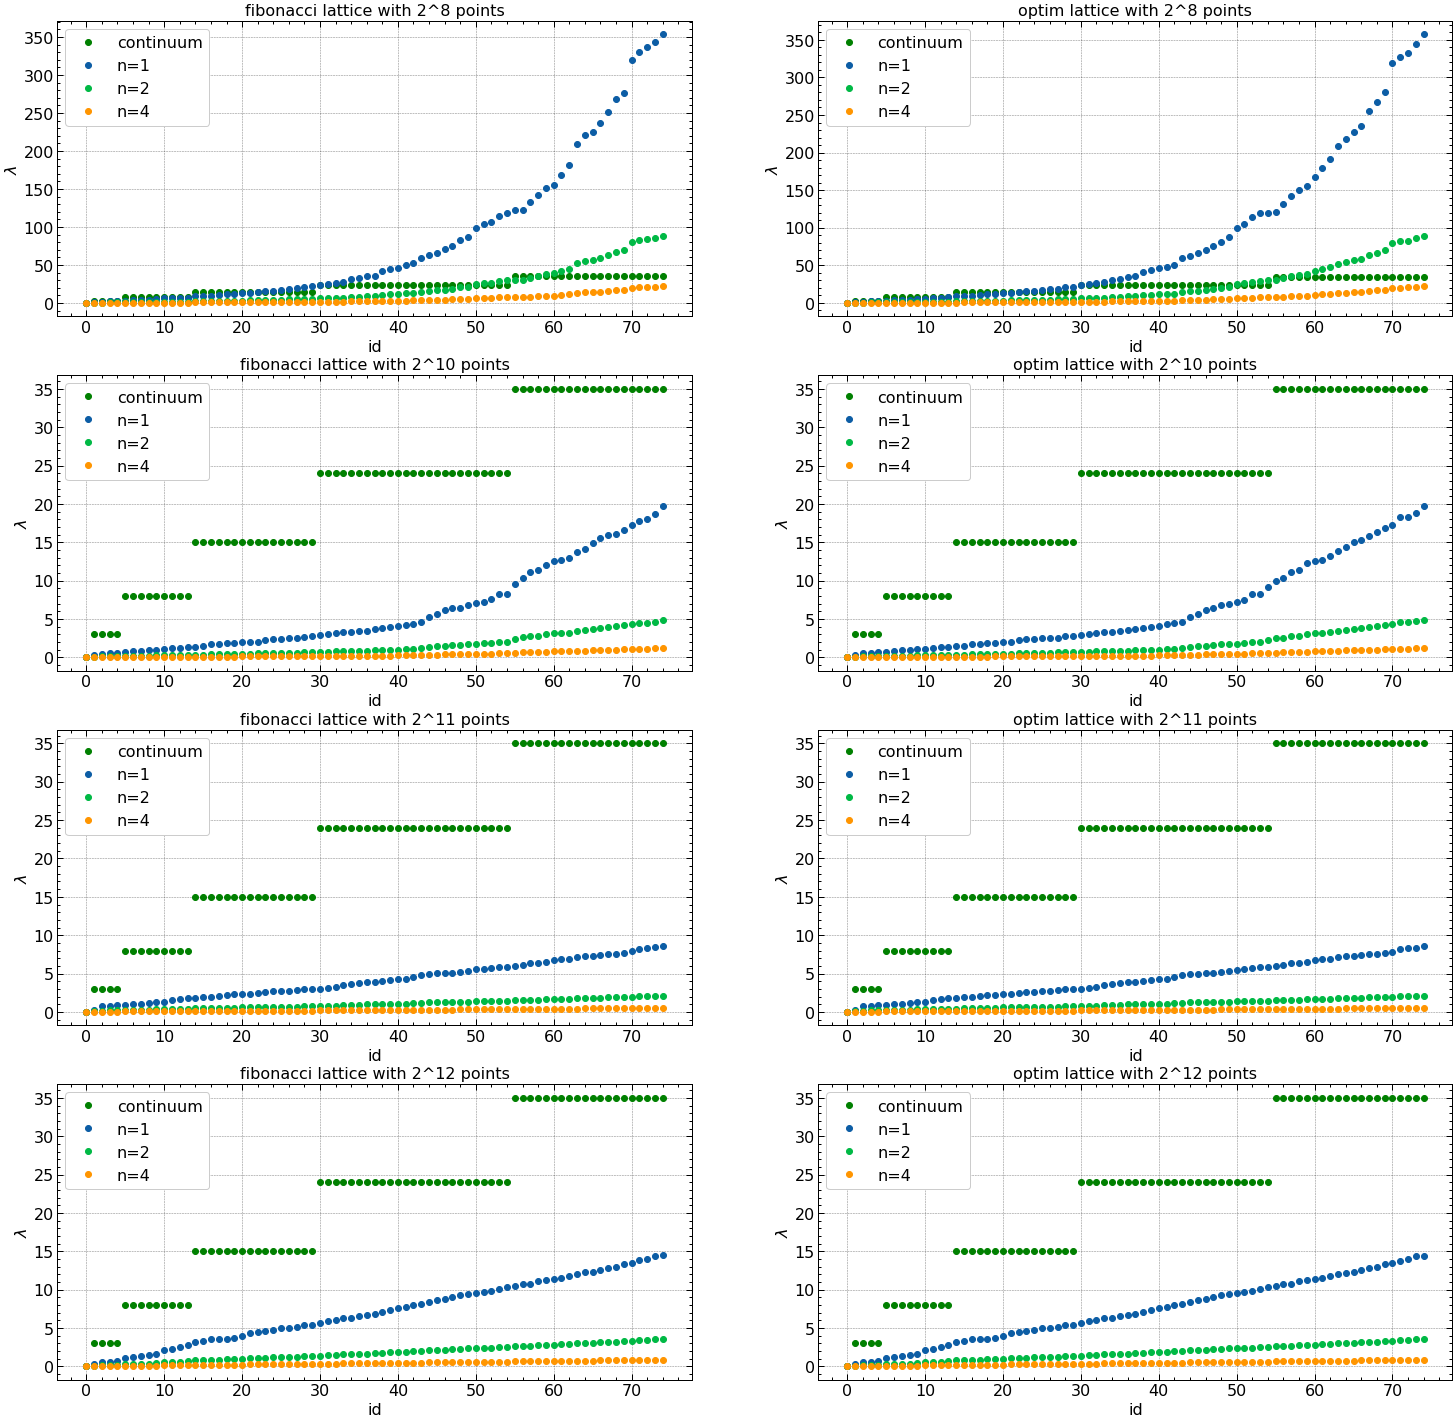

In [10]:
fig, axes = plt.subplots(len(exponents),2,figsize=(25,25))

for index, exponent in enumerate(exponents):
    ax = axes[index,:]
    ax[0].plot(id_s, eigenvals, "o", label = "continuum", color="green")
    ax[1].plot(id_s, eigenvals, "o", label = "continuum", color="green")
    for i,n in enumerate(neighbors):
        ax[0].plot(id_s, fib_eigenvals[i,index,:], "o", label=rf"n={n}")
        ax[1].plot(id_s, optim_eigenvals[i,index,:], "o", label=rf"n={n}")
    ax[0].set_title(rf"fibonacci lattice with 2^{exponent} points")
    ax[1].set_title(rf"optim lattice with 2^{exponent} points")
    ax[0].legend(loc="best")
    ax[1].legend(loc="best")
    ax[0].set_xlabel("id")
    ax[1].set_xlabel("id")
    ax[0].set_ylabel(r"$\lambda$")
    ax[1].set_ylabel(r"$\lambda$")


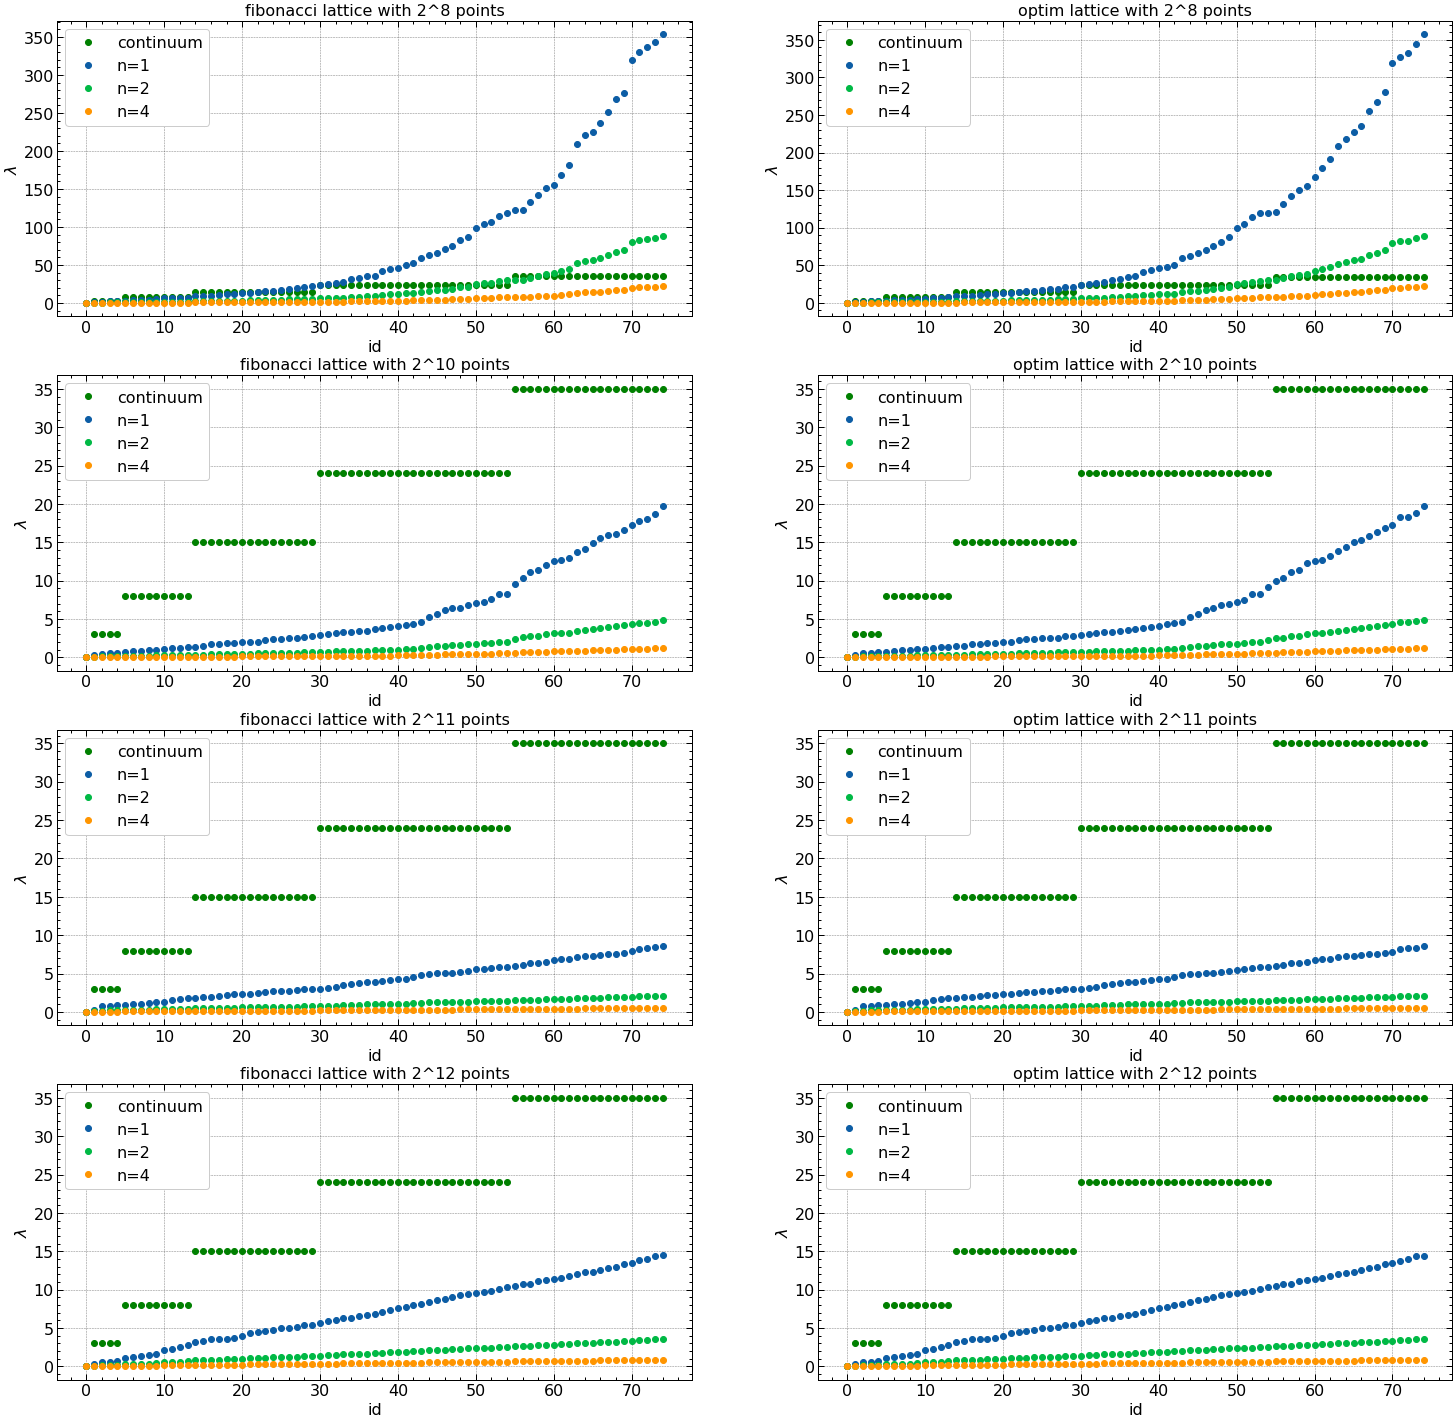

In [11]:
fig, axes = plt.subplots(len(exponents),2,figsize=(25,25))

for index, exponent in enumerate(exponents):
    ax = axes[index,:]
    ax[0].plot(id_s, eigenvals, "o", label = "continuum", color="green")
    ax[1].plot(id_s, eigenvals, "o", label = "continuum", color="green")
    for i,n in enumerate(neighbors):
        ax[0].plot(id_s, fib_eigenvals[i,index,:], "o", label=rf"n={n}")
        ax[1].plot(id_s, optim_eigenvals[i,index,:], "o", label=rf"n={n}")
    ax[0].set_title(rf"fibonacci lattice with 2^{exponent} points")
    ax[1].set_title(rf"optim lattice with 2^{exponent} points")
    ax[0].legend(loc="best")
    ax[1].legend(loc="best")
    ax[0].set_xlabel("id")
    ax[1].set_xlabel("id")
    ax[0].set_ylabel(r"$\lambda$")
    ax[1].set_ylabel(r"$\lambda$")




##### Idea:
use and maximise
\begin{equation*}
    y = \frac{1}{N}\sum_{i \ne j} d(X_i, X_j) + \lambda(R-1)
\end{equation*}
by using spherical coordinates and restricting the sum to the nearest n neighbors of each Lattice point $X_i$ now consisting of the three angles $X_i = (\psi_i, \theta_i, \Phi_i)$
\begin{equation*}
    y = \frac{1}{N}\sum_{i \ne j} NO
\end{equation*}
(this is the mean distance of the nearest n neighbors of each Lattice point; $N = n\cdot dim(X_i)$)

##### Implementation:
then calculating the gradient $\nabla y$ and iteratively adding it to the current Lattice coordinates as
\begin{equation*}
    X_{new} = X_{old} + d\nabla y
\end{equation*}

using the difference $|y_{new} - y_{old}| < \epsilon$ as a cutoff as well as the factor $d$ (I don't know why using this as $d$ works as well as it does)

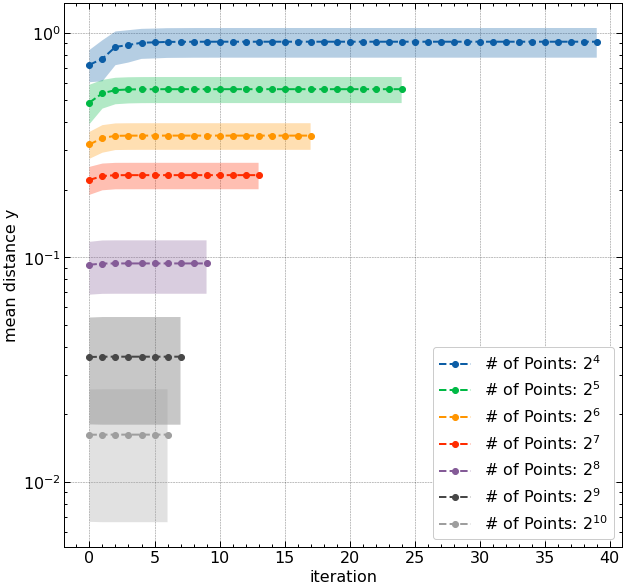

In [21]:
from lattice_optimisation import lattice_optimizer
from fibonacci import generate_vertices_angles

figsize = (10,10)
N = np.array([i for i in range(4,11)])
eps = 1e-14
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr,std = lattice_optimizer(angles, eps=eps, neighbors=1)
    
    arr = np.asarray(arr)
    std = np.asarray(std)
    plt.plot(arr,"o--", label=r"# of Points: $2^{%s}$" %exp)
    plt.fill_between(range(len(arr)), arr-std, arr+std, alpha=0.3)



plt.xlabel("iteration")
plt.ylabel("mean distance y")
plt.legend(loc="best")
#plt.title("one neighbor")
plt.yscale("log")
#plt.savefig("optimiser_mean_distances_one_neighbor.pdf")
plt.show()

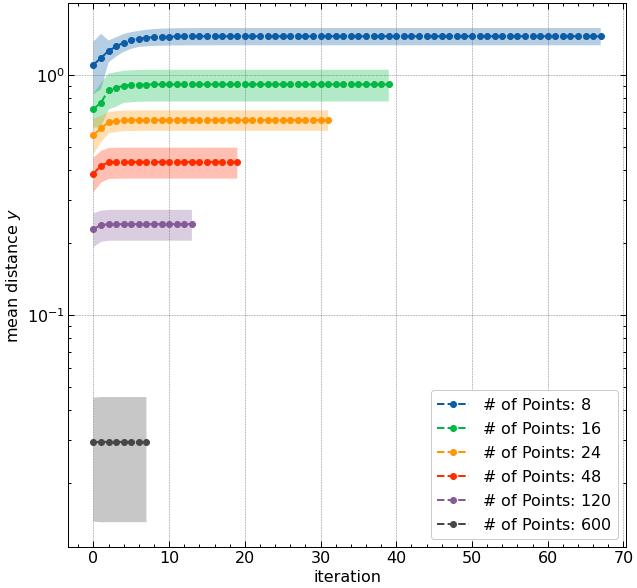

In [28]:
from lattice_optimisation import lattice_optimizer
from fibonacci import generate_vertices_angles

figsize = (10,10)
N = np.array([8,16,24,48,120,600])

eps = 1e-14
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(exp)
    _,mean,arr,std = lattice_optimizer(angles, eps=eps, neighbors=1)
    
    arr = np.asarray(arr)
    std = np.asarray(std)
    plt.plot(arr,"o--", label=r"# of Points: $%s$" %exp)
    plt.fill_between(range(len(arr)), arr-std, arr+std, alpha=0.3)



plt.xlabel("iteration")
plt.ylabel(r"mean distance $y$")
plt.legend(loc="best")
#plt.title("one neighbor")
plt.yscale("log")
#plt.savefig("optimiser_mean_distances_one_neighbor.pdf")
plt.show()

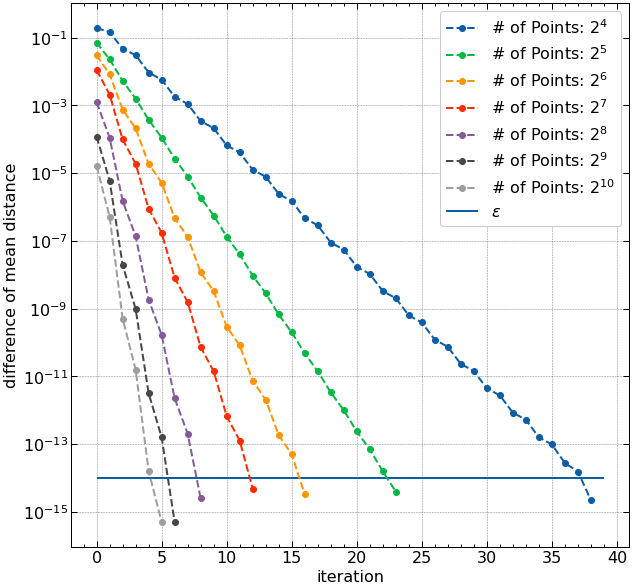

In [12]:
N = np.array([i for i in range(4,11)])
eps = 1e-14
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr, std = lattice_optimizer(angles, eps=eps, neighbors=1)
    arr = (mean-arr)[:-1]

    arr = np.asarray(arr)
    std = np.asarray(std)[:-1]
    plt.plot(arr,"o--", label=r"# of Points: $2^{%s}$" %exp)

plt.hlines(eps, 0,39, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("difference of mean distance")
plt.legend(loc="best")
#plt.title("one neighbor")
plt.yscale("log")
#plt.savefig("optimiser_differences_one_neighbor.pdf")
plt.show()

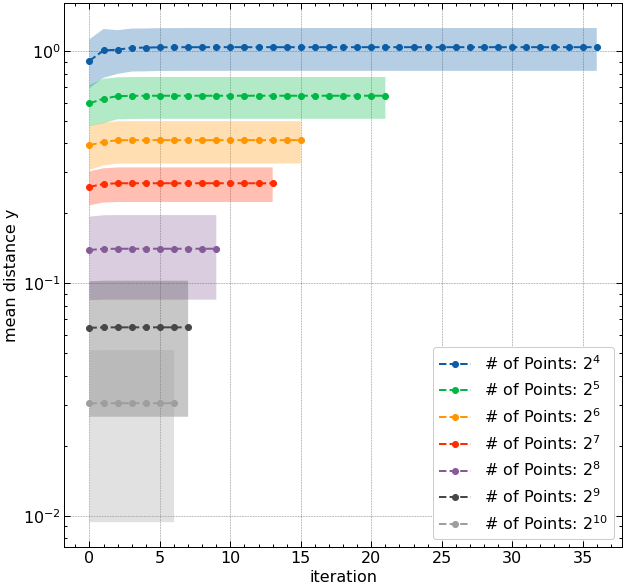

In [19]:
N = np.array([i for i in range(4,11)])
eps = 1e-14
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr, std = lattice_optimizer(angles, eps=eps, neighbors=3)
    arr = np.asarray(arr)
    std = np.asarray(std)
    plt.plot(arr,"o--", label=r"# of Points: $2^{%s}$" %exp)
    plt.fill_between(range(len(arr)), arr-std, arr+std, alpha=0.3)

plt.xlabel("iteration")
plt.ylabel("mean distance y")
plt.legend(loc="best")
#plt.title("three neighbors")
plt.yscale("log")
plt.savefig("optimiser_mean_distances_three_neighbor.pdf")
plt.show()

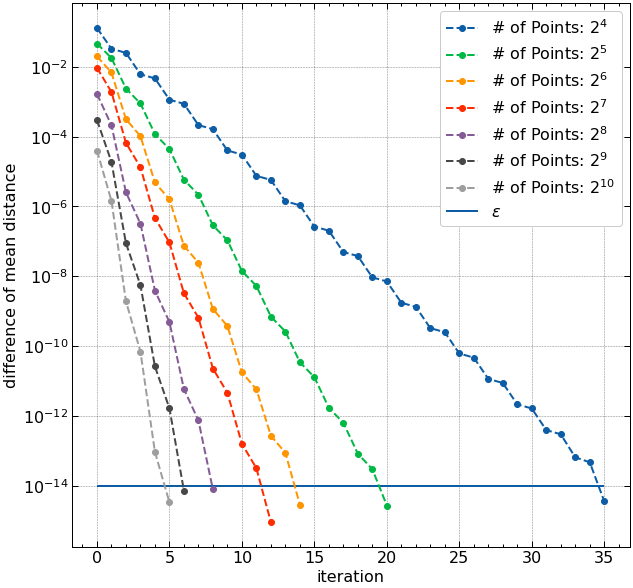

In [18]:
N = np.array([i for i in range(4,11)])
eps = 1e-14
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr,_ = lattice_optimizer(angles, eps=eps, neighbors=3)
    arr = (mean-arr)[:-1]
    plt.plot(arr,"o--", label=r"# of Points: $2^{%s}$" %exp)

plt.hlines(eps, 0,35, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("difference of mean distance")
plt.legend(loc="best")
#plt.title("three neighbors")
plt.yscale("log")
plt.savefig("optimiser_differences_three_neighbor.pdf")
plt.show()

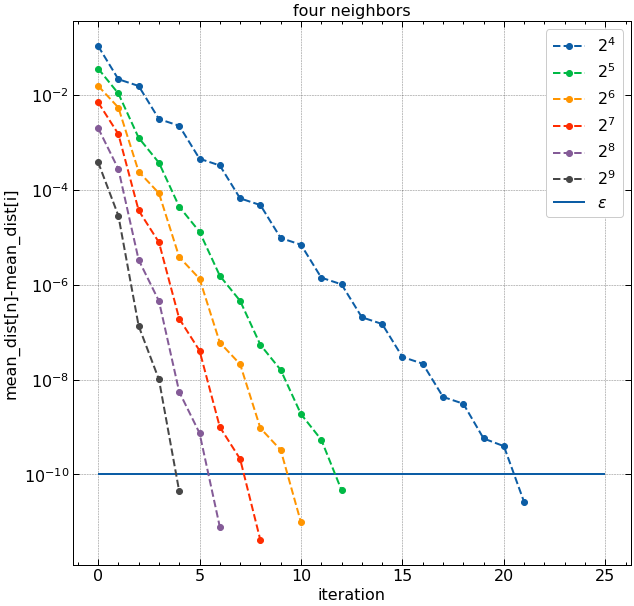

In [26]:
N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr,_ = lattice_optimizer(angles, eps=eps, neighbors=4)
    arr = (mean-arr)[:-1]
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.hlines(eps, 0,25, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("four neighbors")
plt.yscale("log")
plt.show()

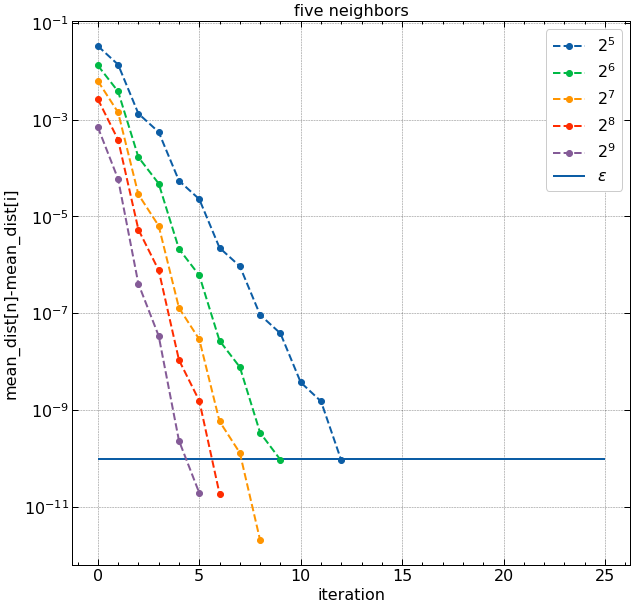

In [27]:
N = np.array([i for i in range(5,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr,_ = lattice_optimizer(angles, eps=eps, neighbors=5)
    arr = (mean-arr)[:-1]
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.hlines(eps, 0,25, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("five neighbors")
plt.yscale("log")
plt.show()